# Statistical Significance

## Introduction

In the world of biostatistics, we often face a crucial question: Does the data we've gathered reveal a _true effect_, or is it simply the result of _random chance_? The concept of **statistical significance** offers a framework to grapple with this uncertainty, providing a tool to help us discern _meaningful_ patterns from the _noise_ inherent in biological systems. This chapter delves into the core of statistical significance, exploring why it matters, when it's most useful, and how it can be a valuable guide in drawing conclusions from the data. Importantly, we'll also discuss the potential pitfalls of relying too heavily on this concept, as well as when alternative approaches might be more appropriate.

## The reproducibility challenge of P-values

### The variability of P-values under a true effect

P-values, a cornerstone of statistical significance testing, can often give the illusion of definitive answers. However, they are inherently sensitive to the specific data set at hand, leading to a reproducibility challenge. To illustrate this, let's consider a Python simulation:

In [1]:
import numpy as np
from scipy.stats import ttest_ind

# For reproducibility
np.random.seed(111)

# Parameters
sample_size = 10
population_std_dev = 5.0
mean_difference = 5.0
num_simulations = 1000

# Store p-values
p_values = []

# Run simulations
for _ in range(num_simulations):
    # Sample from two populations with different means
    data1 = np.random.normal(0, population_std_dev, sample_size)
    data2 = np.random.normal(mean_difference, population_std_dev, sample_size)
    
    # Perform t-test
    _, p_value = ttest_ind(data1, data2)
    p_values.append(p_value)

# Analyze p-values
print("Proportion of P-values < 0.05:", np.mean(np.array(p_values) < 0.05))

Proportion of P-values < 0.05: 0.592


This code repeatedly samples 10 data points from two Gaussian distributions with the same standard deviation (5.0) but a mean difference of 5.0, so under a _true effect_. Each time, it performs a **t-test** to compare the means and records the resulting p-value.

What we often find is a surprising inconsistency. Even though the underlying populations have a true difference in means, the proportion of P-values considered "statistically significant" (typically below 0.05) fluctuates significantly across simulations. This highlights the inherent variability of p-values and the potential for misleading conclusions when a single analysis is treated as definitive.

The 2.5th and 97.5th percentiles are [1.69152124e-04 7.02604441e-01]


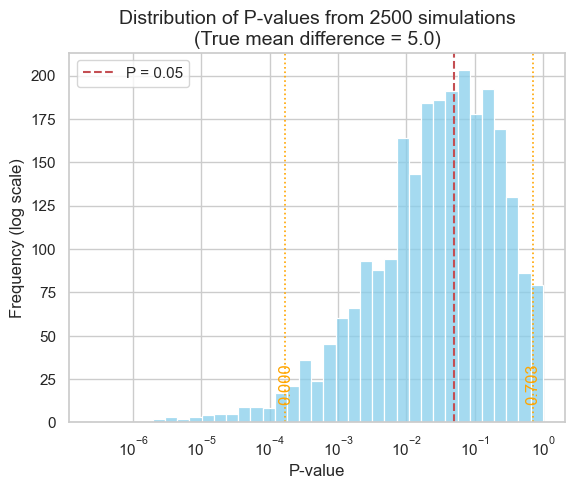

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(111)

# Simulation parameters
N = 10      # Sample size per group
SD = 5.0    # Standard deviation
mean = 0    # Mean of the first population
num_simulations = 2500

# Store p-values
p_values = []

# Run simulations
for _ in range(num_simulations):
    pop_1 = np.random.normal(loc=mean, scale=SD, size=N)
    pop_2 = np.random.normal(loc=mean + 5, scale=SD, size=N)  
    _, p_value = ttest_ind(pop_1, pop_2)
    p_values.append(p_value)

# Calculate percentiles
percentiles = np.percentile(p_values, [2.5, 97.5])  # Get 2.5% and 97.5% percentiles
print(f"The 2.5th and 97.5th percentiles are {percentiles}")

# Plotting
sns.set_theme(style="whitegrid") # Optional: set a clean seaborn style
# plt.figure(figsize=(10, 6))
# Histogram with log scale
sns.histplot(p_values, kde=False, log_scale=True, color="skyblue")
# Vertical line at p=0.05
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=1.5, label="P = 0.05")

# Add percentile lines and annotations
for p in percentiles:
    plt.axvline(p, color='orange', linestyle='dotted', linewidth=1.2)
    plt.text(p, 10, f"{p:.3f}", color='orange', rotation=90, va='bottom', ha='center')

plt.xlabel("P-value", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title(
    "Distribution of P-values from 2500 simulations\n(True mean difference = 5.0)",
    fontsize=14)
plt.legend();

As our simulation demonstrates, the middle 95% of P-values can span a vast range, from as low as 0.000169 to as high as 0.7026 - a difference of over three orders of magnitude! This immense variability underscores a crucial point: P-values are far less reproducible than most researchers anticipate.

This lack of reproducibility has significant implications for the conclusions we draw about statistical significance. Consider a study that finds a P-value of exactly 0.05, barely crossing the threshold for significance. If this study were repeated, there's only a 50% chance that the new P-value would also be below 0.05, as revealed by simulations:

| Initial P value | Probability of P-value < 0.05 in replication |
|:--------------- |:-------------------------------------------- |
| 0.10            | 38 %                                         |
| 0.05            | 50 %                                         |
| 0.01            | 73 %                                         |
| 0.001           | 91 %                                         |
| 0.00031         | 95 %                                         |

In other words, even a seemingly "significant" finding is surprisingly susceptible to being overturned by chance in subsequent experiments.

This phenomenon isn't limited to borderline cases. Even with a highly "significant" initial P-value of 0.001, there's no guarantee that a repeat study will yield a P-value below the traditional 0.05 threshold. This highlights a fundamental truth: statistical significance, as determined by P-values, is not a static property of a phenomenon but rather a probabilistic outcome dependent on the specific data at hand.

### The risk of false positives under the null hypothesis

While the variability of P-values under a true effect is a concern, an even more insidious issue arises when there is no real effect to be found. In this scenario, the _null hypothesis is true_, yet random sampling can still lead to statistically significant results. This simulation explores the frequency of such false positives and their implications for drawing reliable conclusions.

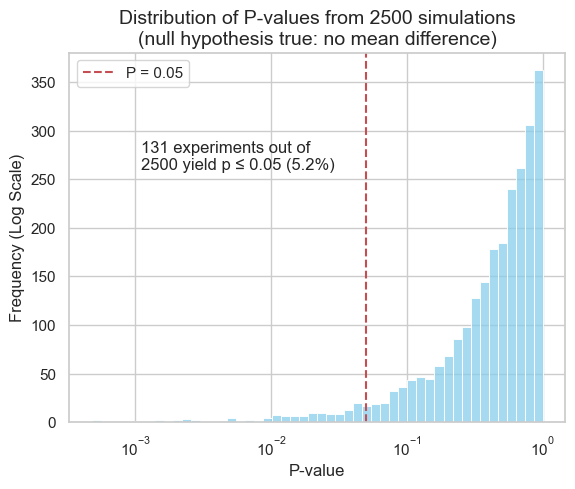

In [3]:
# Simulation parameters
N = 10      # Sample size per group
SD = 5.0    # Common standard deviation
mean = 10   # Common mean for both populations
num_simulations = 2500

# For reproducibility
np.random.seed(111)

# Store p-values
p_values = []

# Run simulations
for _ in range(num_simulations):
    pop_1 = np.random.normal(loc=mean, scale=SD, size=N)
    # Same mean and SD for both populations, same sample size
    pop_2 = np.random.normal(loc=mean, scale=SD, size=N)
    _, p_value = ttest_ind(pop_1, pop_2)
    p_values.append(p_value)

# Calculate significance proportion
signif_proportion = np.mean(np.array(p_values) <= 0.05)

# Plotting
sns.set_theme(style="whitegrid")
# plt.figure(figsize=(10, 6))
sns.histplot(p_values, kde=False, log_scale=True, color="skyblue")
plt.axvline(
    0.05,
    color='r', linestyle='dashed', linewidth=1.5,
    label="P = 0.05")
plt.xlabel("P-value", fontsize=12)
plt.ylabel("Frequency (Log Scale)", fontsize=12)
plt.title(
    "Distribution of P-values from 2500 simulations\n\
(null hypothesis true: no mean difference)",
    fontsize=14)
plt.text(
    0.0011, 290,
    f"{int(signif_proportion * num_simulations)} experiments out of \n\
{num_simulations} yield p ≤ 0.05 ({signif_proportion:.1%})", 
    fontsize=12, ha="left", va="top") 
plt.legend();

In our simulation, where both populations had the same mean, approximately 5% of the experiments yielded P-values below the 0.05 significance threshold. This phenomenon is known as a **Type I error**, or a **false positive**. This aligns with the chosen significance level, highlighting that statistical significance does not guarantee a true effect. 

This underscores the importance of interpreting P-values cautiously and considering them within the broader context of the research question, effect size, and potential for replication.

### The influence of sample size on P-values

The size of the sample (the number of observations in each group) plays a crucial role in determining the outcome of a statistical test. Even with the same underlying effect size and variability, a larger sample size can drastically alter the resulting P-value. Let's illustrate this with a simulation using the t-distribution's cumulative distribution function (CDF). Here the number of degrees of freedom equals $n_1 + n_2 - 2$ which, with $n_1 = n_2 = n$, equals $2 \times n - 2$.

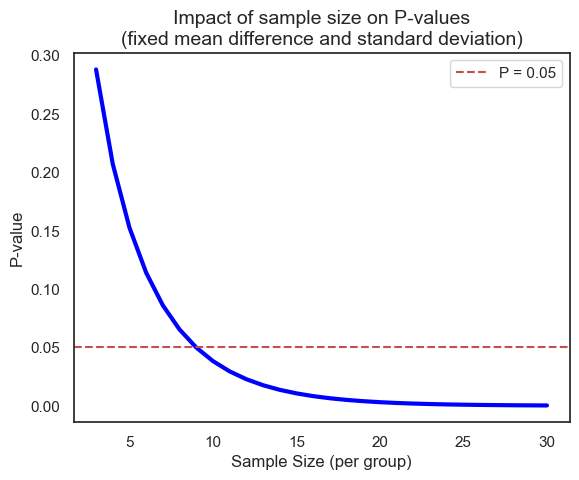

In [4]:
from scipy.stats import t

# Simulation parameters
mean1, mean2 = 10, 15       # Group means (fixed difference)
mean_diff = mean2 - mean1
SD = 5                      # Standard deviation (fixed)

p_values = []

for n in range(3, 31):      # Varying sample sizes
    # Calculate t-statistic (see previous chapter)
    t_stat = mean_diff / (SD * (2 / n)**0.5)
    p_value = 2 * (1 - t.cdf(x=abs(t_stat), df=2*n-2))  # Two-tailed p-value
    p_values.append(p_value)

# Plotting
sns.set_theme(style="white")
# plt.figure(figsize=(10, 6))
sns.lineplot(x=list(range(3, 31)), y=p_values, lw=3, color="blue")
plt.xlabel("Sample Size (per group)", fontsize=12)
plt.ylabel("P-value", fontsize=12)
plt.title(
    "Impact of sample size on P-values\n\
(fixed mean difference and standard deviation)",
    fontsize=14)
plt.axhline(
    0.05,
    color='r', linestyle='dashed', linewidth=1.5,
    label="P = 0.05")
plt.legend();

Of course, we can achieve the same results using both `scipy.stats.ttest_ind` (for the t-test) and directly working with the t-distribution, because the t-test relies on the t-distribution to model the behavior of the test statistic under the null hypothesis (will be discussed in later chapter).

In [5]:
# Sample data (two groups)
data1 = [8, 11, 12, 9, 14]
data2 = [15, 18, 17, 16, 20]

# Method 1: Using scipy.stats.ttest_ind
t_stat, p_value_ttest = ttest_ind(data1, data2)

# Method 2: Calculating directly from t-distribution
n1, n2 = len(data1), len(data2)                # Sample sizes
df = n1 + n2 - 2                               # Degrees of freedom
mean1, mean2 = np.mean(data1), np.mean(data2)  # Sample means
pooled_std = np.sqrt(
    (   # Pooled standard deviation
        (n1 - 1) * np.var(data1, ddof=1) + (n2 - 1) * np.var(data2, ddof=1)
    ) / df
)
t_stat_manual = (mean1 - mean2) / (pooled_std * np.sqrt(1/n1 + 1/n2))

# Calculate p-value using t-distribution CDF
p_value_manual = 2 * (1 - t.cdf(abs(t_stat_manual), df=df)) 

print("Results using ttest_ind:")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value_ttest:.4f}")

print("\nResults using manual calculation:")
print(f"t-statistic: {t_stat_manual:.4f}, p-value: {p_value_manual:.4f}")

Results using ttest_ind:
t-statistic: -4.6677, p-value: 0.0016

Results using manual calculation:
t-statistic: -4.6677, p-value: 0.0016


### The danger of ad hoc sample size decisions and cumulative P-values

In research, it's tempting to collect data _incrementally_ and assess statistical significance after each addition. However, this **ad hoc** approach to sample size can lead to misleading conclusions. Let's simulate how cumulative P-values behave under the null hypothesis, where there's no true difference between groups.

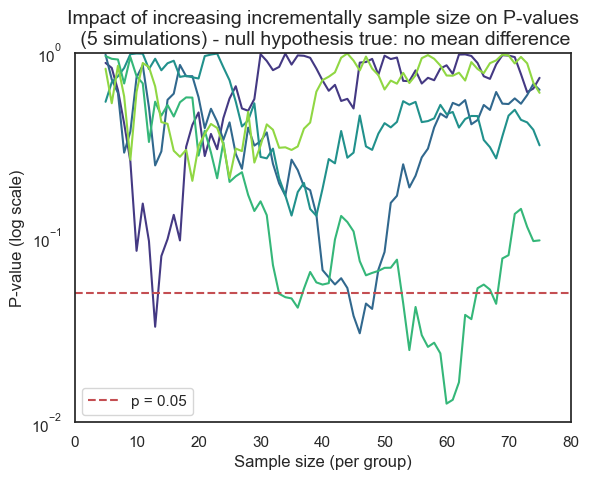

In [6]:
# Simulation parameters
sample_size_max = 75
num_simulations = 5
common_mean = 0
common_std_dev = 1.0

# Seaborn color palette
palette = sns.color_palette("viridis", n_colors=num_simulations)

# For reproducibility
np.random.seed(111)

# Plotting setup
# plt.figure(figsize=(10, 6))
sns.set_theme(style="white")

# Run simulations and plot
for sim_num in range(num_simulations):
    # Generate data for two populations with the same mean and SD
    pop_1 = np.random.normal(
        loc=common_mean, scale=common_std_dev, size=sample_size_max)
    pop_2 = np.random.normal(
        loc=common_mean, scale=common_std_dev, size=sample_size_max)

    p_values = []
    sample_sizes = list(range(5, sample_size_max + 1))

    # Iterate over increasing sample sizes
    for n in sample_sizes:
        _, p_value = ttest_ind(pop_1[:n], pop_2[:n])
        p_values.append(p_value)

    # Plot for this simulation using the Seaborn palette
    sns.lineplot(
        x=sample_sizes, y=p_values,
        # marker='o',
        color=palette[sim_num],
        # alpha=0.7, 
        # label=f"Simulation {sim_num + 1}",
    )

# Add labels and title
plt.axhline(
    0.05,
    color='r', linestyle='dashed', linewidth=1.5,
    label='p = 0.05')
plt.xlabel("Sample size (per group)", fontsize=12)
plt.ylabel("P-value (log scale)", fontsize=12)
plt.title(
    f"Impact of increasing incrementally sample size on P-values\n \
({num_simulations} simulations) - null hypothesis true: no mean difference",
    fontsize=14)
plt.yscale('log')
plt.ylim((0.01, 1))
plt.xlim((0, sample_size_max + 5))
# plt.grid(axis='y', linestyle='--')
plt.legend();

Consider the potentially misleading practice of collecting data until a statistically significant result is achieved, then abruptly stopping the experiment. This approach capitalizes on the inherent randomness of sampling. If data collection were to continue beyond the initial "significant" finding, the P-value might fluctuate back into the non-significant range as new data points are added.

This is evident with the first line in our previous simulation (where the curve rises between 13 and 14). However, for other samples, the rise of the P-value back into non-significance could occur later or even never happen, leaving a false sense of confidence in the results. In real-world research, this fluctuation would often remain hidden due to the premature halt of data collection.

This dynamic adjustment of sample size, known as **sequential data analysis**, introduces **bias** and inflates the rate of **false positives** (**Type I errors**). It's a statistical illusion, creating the misleading impression of a significant effect where none truly exists.

## Confidence intervals and P-values

Confidence intervals offer a valuable alternative to P-values for assessing statistical significance. They provide a _range of plausible values for the true population parameter_ (e.g., mean difference, effect size) with a specified level of confidence (typically 95%). Unlike P-values, which focus solely on rejecting or failing to reject a null hypothesis, confidence intervals offer a more informative picture of the magnitude and uncertainty of an effect.

There's a direct relationship between confidence intervals and P-values, particularly for two-sided tests:

- **95% CI excludes the null value**: If the 95% confidence interval for a parameter (e.g., mean difference) does not include the null hypothesis value (often 0 for differences or 1 for ratios), then the corresponding P-value will be less than 0.05, indicating a **statistically significant** result.
- **95% CI includes the null value**: Conversely, if the 95% confidence interval does contain the null hypothesis value, the P-value will be greater than or equal to 0.05, suggesting that the results are **not statistically significant**.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1063458412007789-gr1.jpg" alt="Statistically and clinically significant effects, measured in arbitrary units on an absolute scale, as evaluated by P-values and confidence intervals" style="width: 600px;"/>

Examples:

- Comparing means: If the 95% CI for the difference between two means does not include zero, we can conclude a statistically significant difference exists between the groups (P < 0.05).
- Comparing proportions: If the 95% CI for the ratio of two proportions does not include 1.0, we can conclude a statistically significant difference exists (P < 0.05).
- Comparing percentages: If we're testing whether a set of percentages differs from a hypothesized value of 100, and the 95% CI of the mean of the percentages excludes 100, then the discrepancy is statistically significant.

Confidence intervals offer several advantages over P-values alone:

- Effect size estimation: CIs provide an estimate of the magnitude of the effect, not just whether it's statistically significant.
- Precision assessment: The width of the CI reflects the precision of the estimate. Narrower CIs indicate more precise estimates.
- Decision relevance: CIs help assess the practical significance of the effect by showing the range of plausible values.

In biostatistics and many other fields, it's increasingly recommended to report confidence intervals alongside P-values. This provides a more comprehensive and informative view of our findings, allowing for better decision-making based on both statistical significance and the estimated magnitude of the effect.

## Statistical significance and hypothesis testing

Statistical hypothesis testing offers a standardized framework for drawing conclusions from data. At its core, this approach streamlines the complex process of interpreting results by distilling findings into a **binary outcome**: "statistically significant" or "not statistically significant." This automation of decision-making can be both a strength and a weakness. In this section, we'll delve deeper into the principles of hypothesis testing, exploring how it simplifies decision-making, the criteria it relies upon, and the potential pitfalls that arise from oversimplification. We'll also discuss when and how hypothesis testing can be a valuable tool in the biostatistical arsenal.

### Type I and type II errors

The binary nature of statistical hypothesis testing (reject H0 or do not reject H0) creates a landscape of potential errors, as our decisions are made under uncertainty. These errors are classified into two distinct types, each with its own consequences:

|             | Reject H0    | Do not reject H0 |
| ----------- | ------------ | ---------------- |
| H0 is true  | Type I error | (no error)       |
| H0 is false | (no error)   | Type II error    |

- **Type I error** (**False Positive**): this occurs when we reject the null hypothesis (H0) even though it's actually true. In other words, we conclude there's a significant effect when, in reality, it's due to chance. Think of this as a "false alarm". In everyday life, we might mistakenly flag a legitimate email as spam or, more seriously, wrongly convict someone of a crime they didn't commit.

- **Type II error** (**False Negative**): This happens when we fail to reject the null hypothesis (H0) when it's actually false. This means we miss a real effect and incorrectly conclude there's no significant difference. Consider this a "missed opportunity." In everyday life, we might mistakenly let a spam email slip into our inbox or, more seriously, wrongly acquit someone who actually committed a crime.

A third type of error, known as a **Type S** or **Type III error**, occurs when the direction of the effect is incorrectly concluded. In other words, we might find a statistically significant difference, but the direction of that difference is the _opposite_ of what is actually true. Imagine a study that aims to determine if a new drug lowers blood pressure. A Type S error would occur if the study concludes that the drug raises blood pressure when it actually lowers it, even though the statistical test shows a significant difference.

### Interpreting statistical significance

#### The significance level ($\alpha$)

When a statistical test yields a "significant" result, it means the observed effect is unlikely to have occurred by chance alone, given a pre-specified threshold of improbability. This threshold is known as the significance level, denoted by the Greek letter alpha ($\alpha$).

Typically, researchers set alpha at 0.05, meaning there's a 5% chance of incorrectly rejecting the null hypothesis (H0) when it's actually true (a Type I error). A P-value less than alpha leads to rejecting H0, while a P-value greater than or equal to alpha leads to failing to reject H0.

While a significant result ($P < \alpha$) suggests an effect is unlikely due to chance, it doesn't guarantee the effect is:

- Large: a small effect can be statistically significant with a large enough sample size.
- Important: statistical significance doesn't equate to practical or clinical significance.
- Accurate: a significant result could still be a Type I error.

Now, we can ask ourselves:

- Assuming the null hypothesis is true, what is the probability of obtaining a P-value that would lead us to incorrectly reject the null hypothesis?
- If we repeatedly conduct experiments where there is no true effect, what proportion of these experiments will mistakenly lead us to conclude that there is a significant effect?

In practical terms, $\alpha$ can also be understood through repeated experimentation. Imagine conducting numerous experiments where the null hypothesis (H0) is true. Let $A$ represent the number of times we incorrectly reject H0 (Type I errors), and let $B$ represent the number of times we correctly fail to reject H0:

|             |  Reject H0  | Do not reject H0 |  Total  |
| ----------- |:-----------:|:----------------:|:-------:|
| H0 is true  |  A (Type I) |        B         |  A + B  |
| H0 is false |      C      |   D (Type II)    |  C + D  |
| Total       |    A + C    |      B + D       | A+B+C+D |


The significance level only considers analyses where _H0 is true_ (first row of the table). Of all experiments ($A+B$), the number of times H0 is rejected equals $A$, so that:

$$\alpha = \frac{A}{A+B}$$

In other words, $\alpha$ is the proportion of experiments where we mistakenly reject H0 when it's actually true. This highlights a key point: even when there is no real effect, a certain percentage of studies will yield statistically significant results simply due to random chance.

#### The False Positive Report Probability (FPRP)

While $\alpha$ focuses on the risk of a Type I error within a single experiment, the False Positive Report Probability (FPRP) takes a broader perspective. It considers the probability that a statistically significant finding in a research report actually represents a false positive result.

The FPRP acknowledges that research doesn't exist in isolation. In practice, multiple studies are often conducted to investigate a particular phenomenon. Some of these studies might yield significant results by chance (Type I errors). The FPRP asks: given a significant finding in a published report, what's the probability that this result is actually a false positive?

The FPRP only considers analyses that **reject H0** (first column of the table). Of all these studies that report a statistically significant result (reject H0) $A+C$, and with $C$ the number of studies that report a significant result and where H0 is truly false (true positive), the number in which H0 is true equals $A$, therefore:

$$\text{FPRP} = \frac{A}{A+C}$$

In other words, the FPRP is the proportion of significant results that are actually false positives.

### The prior probability influences the FPRP

The False Positive Report Probability (FPRP) isn't a fixed value; it varies depending on several factors, including the significance level ($\alpha$) and statistical power of the study. However, an often overlooked but critical factor is the **prior probability** of a true effect. This reflects our _existing knowledge_ or _belief_ about the likelihood of the phenomenon under investigation before we even conduct the experiment.

Intuitively, if we're testing a hypothesis that seems highly implausible based on prior research or scientific understanding, even a statistically significant result should be met with greater skepticism. In contrast, a significant finding for a well-established phenomenon is more likely to be a true positive.

The table below illustrates how the FPRP changes depending on the prior probability of a true effect, assuming a fixed significance level and power.

| Prior probability | FPRP as P<0.05 | FPRP as 0.045<P<0.05 |
| ----------------- | -------------- | -------------------- |
|         0%        |      100%      |         100%         |
|         1%        |       86%      |          97%         |
|        10%        |       36%      |          78%         |
|        50%        |      5.9%      |          27%         |
|       100%        |        0%      |           0%         |

Let's explore these scenarios to understand the nuanced relationship between FPRP and the broader scientific context.

#### Prior probability = 1%

Consider a scenario where we're testing 1,000 new drug compounds, but prior research indicates that the probability of any single drug being successful is a mere 1%. What can we expect in terms of both true and false positive findings?

_We need to consider not just the risk of false positives, but also the chance of missing a truly effective drug (a false negative). This is where the concept of **power** comes in. We will discuss it in more details in another section, but briefly, power is the probability that our experiment will correctly identify a truly effective drug as significant. In this case, with a 1% prior probability, a high-powered study is crucial. If our study has low power, we might miss out on most of the effective drugs, even if they exist._

- Of 1000 drugs screened we expect 10 (1%) that really work
- Of the 10 drugs that really work we expect to obtain a statistically significant result in 8 (80 % power)
- Of the 990 drugs that are really ineffective we expect to obtain a statistically significant result in 5% ($\alpha$ set to 0.05), i.e. $5\% \times 990 = 49$ false positive
- Of 1000 tests of different drugs we therefore expect to obtain statistically significant difference in $8+49=57$
- The FPRP equals $49/57=86%$

```markdown
            8 have P<0.05 (80% power)
           /
       10 work (prior probability=50%)
      /    \
     /      2 have P>0.05
1000 drugs
     \          49 have P<0.05 (5% significance level)
      \        /
       990 don't work
               \
                941 have P>0.05
```

|                     | Statistically significant | Not significant | Total |
| ------------------- |:-------------------------:|:---------------:|:-----:|
| Drug is ineffective |              49           |       941       |  990  |
| Drug is effective   |               8           |        2        |   10  |
| Total               |              57           |       943       |  1000 |

With such a low prior probability of success (1%), conducting this experiment with a conventional significance level of 5% ($\alpha = 0.05$) is likely to yield a high rate of false positives. This means that many of the drugs identified as 'significant' would actually be ineffective. To ensure the validity and usefulness of this drug screening, a much stricter significance level, such as 0.1% ($\alpha = 0.001$), may be necessary. This stricter threshold would reduce the risk of falsely identifying ineffective drugs as promising candidates, but it would also increase the risk of missing truly effective drugs (Type II errors). Balancing these risks requires careful consideration of the specific context, costs, and potential benefits of the drug screening program.

#### Prior probability = 50%

Even perfectly performed experiments are less reproducible than most expect, and many statistically significant results are false positives in situations where false positive results are likely, e.g. with low prior probability in observational studies or when multiple comparisons are made. In contrast, when the prior probability of a true effect is higher, such as 50%, the likelihood of a significant result being a true positive increases substantially, with here the FPRP equals $25/425 = 5.9%$, even if the study is underpowered:

```markdown
             400 have P<0.05 (80% power)
            /
       500 work (prior probability=50%)
      /     \
     /       100 have P>0.05
1000 drugs
     \          25 have P<0.05 (5% significance level)
      \        /
       500 don't work
               \
                475 have P>0.05
```

|                     | Statistically significant | Not significant | Total |
| ------------------- |:-------------------------:|:---------------:|:-----:|
| Drug is ineffective |              25           |       475       |   500 |
| Drug is effective   |             400           |       100       |   500 |
| Total               |             425           |       943       |  1000 |

Furthermore, if an experiment has low power to find the difference/effect we are looking for, we are likely to end up with a result that is not statistically significant even if the effect is real. And if the low power study does reach a conclusion that the effect is statistically significant, the results are hard to interpret because the FPRP will be high, and the effect size observed in that study is likely to be larger than the actual effect size because only large observed effects (even if due to chance) will yield a P-value less than 0.05. Experiments designed with low power cannot be very informative, and it should not be surprising when they cannot be reproduced.

## The challenge of multiple comparisons

When conducting multiple statistical tests within a study, the probability of encountering at least one false positive result increases significantly. This is known as the multiple comparisons problem.

Each statistical test carries an inherent risk of a Type I error (false positive), and conducting multiple tests compounds this risk. Think of it like rolling the dice multiple times - the more you roll, the higher the chance of getting a "lucky" (but misleading) significant result.

The multiple comparisons problem can lead to false discoveries and unreliable conclusions. In this section, we'll explore the causes and consequences of this issue, and we'll introduce statistical methods to mitigate the inflated risk of false positives.

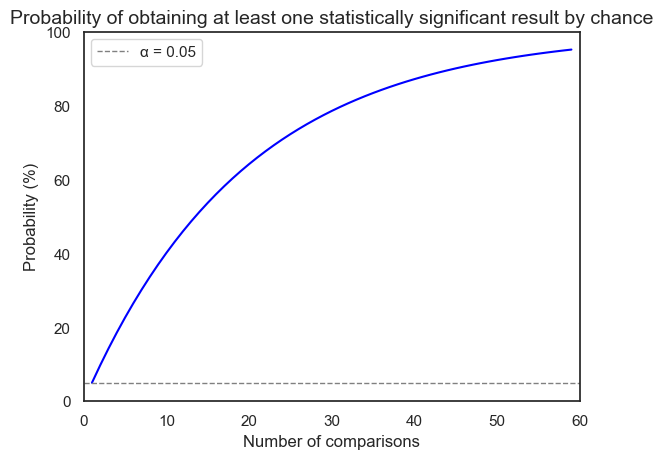

In [7]:
# Data
x = np.arange(1, 60)  # Number of comparisons (1 to 59)
y = 100 * (1 - 0.95**x)  # Probability of at least one significant result (%)

# Plot
# plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=y, color="blue")
plt.axhline(
    5,
    color='gray', linestyle='dashed', linewidth=1,
    label="α = 0.05")  # Add alpha level line
plt.title(
    "Probability of obtaining at least one statistically significant result by chance",
    fontsize=14)
plt.xlabel("Number of comparisons", fontsize=12)
plt.ylabel("Probability (%)", fontsize=12)
plt.xlim(0, 60)
plt.ylim(0, 100)
plt.legend();

This plot illustrate the concept of the multiple comparisons problem. The x-axis represents the number of comparisons made in a study, while the y-axis shows the probability of obtaining at least one statistically significant result purely by chance.

As we can see, even with a single comparison (x=1) and an alpha level of 0.05, there's a 5% chance of getting a false positive. As the number of comparisons increases, this probability rapidly rises. For instance, with just 14 comparisons, the probability of at least one false positive exceeds 50%!

### The Bonferroni correction

The simplest approach to controlling the familywise error rate (FWER) is the **Bonferroni correction**, which involves dividing the desired overall significance level ($\alpha$) by the number of comparisons ($K$): $\alpha_\text{adjusted} = \alpha / K$. This adjustment ensures that if all the null hypotheses are true, the probability of observing at least one false positive (Type I error) among all $K$ comparisons is at most $\alpha$.

The Bonferroni correction does not guarantee exactly a 95% chance of seeing no significant results if all null hypotheses are true. It provides a more conservative upper bound on this probability, making it less likely to make any false discoveries. However, this comes at the cost of reduced power to detect true effects (increased risk of Type II errors).

### The False Discovery Rate (FDR)

The False Discovery Rate (FDR) offers a more flexible alternative to the Bonferroni correction for addressing multiple comparisons. Instead of strictly controlling the probability of any false positives, the FDR aims to control the proportion of false positives among the discoveries we make. The FDR addresses these key questions:

- If a comparison is deemed significant (P-value below a threshold), what's the chance it's actually a false positive (H0 is true)?
- Of all significant findings, what fraction are expected to be false positives?

The desired FDR, often denoted as $Q$, is the acceptable proportion of false discoveries. For example, with Q = 10%, we aim for at least 90% of our significant results to be true positives.

A widely used method to control the FDR is the **Benjamini-Hochberg** procedure. It sets dynamic thresholds for each comparison, depending on its rank among the P-values. For example, if we want an FDR of 5% across 100 comparisons, we would:

1. Rank P-values: Order the P-values from smallest to largest ($P(1), P(2), ..., P(100)$).
2. Calculate Thresholds: For each P-value $P(i)$, calculate a threshold $T(i)$ using this formula $T(i) = (i / m) * Q$, with $i$ the rank of the P-value ($1, 2, ..., 100$), and $m$ the total number of comparisons ($100$)
3. Compare and Decide: If $P(i) \leq T(i)$, declare the comparison as significant, if $P(i) \gt T(i)$, declare the comparison as not significant.

For example, for the smallest P-value ($i = 1$), $T(1) = (1 / 100) \times 0.05 = 0.0005$, so, the smallest P-value would be considered significant if it's less than or equal to 0.0005. The second smallest P-value's threshold would be $(2/100) \times 0.05 = 0.001$. For the largest P-value ($i = 100$), $T(100) = (100 / 100) \times 0.05 = 0.05$, so the largest P-value is compared directly to the overall alpha level (0.05).

This approach ensures that, on average, no more than 5% of the significant results we identify will be false positives.

## Statistical power

### Definition

The **power** of an experimental design answers this crucial question: If there truly is an effect of a specified size, and the experiment is repeated many times, what proportion of those experiments will yield a statistically significant result? This concept is essential for determining sample size requirements and for interpreting results that are not statistically significant.

While the definition of a P-value starts with the assumption that the null hypothesis (H0) is true, we often want to know what happens when H0 is false, and there is a real effect. Statistical power addresses this by asking: if a specific effect truly exists (e.g., a difference between groups, a relative risk, a correlation), what is the probability of obtaining a statistically significant result in a single experiment?

Power is the proportion of hypothetical experiments (if we were to repeat our study many times) in which we would expect to correctly reject the null hypothesis, given that the alternative hypothesis (the effect we're looking for) is actually true

|                     | Decision: Reject H0     | Decision: Fail to reject H0     |
|:------------------- |:-----------------------:|:-------------------------------:|
| No effect (H0 True) | Type I error ($\alpha$) | Correct decision ($1 - \alpha$) |
| Effect exists       | $1 - \beta$             | Type II error ($\beta$)         |

<img src="https://static.wingify.com/gcp/uploads/sites/3/2020/12/graphical-representation-of-type-1-and-type-2-errors.png" alt="type I and type II errors seen in H0 and H1 distributions" style="width: 500px;"/>

Since $\beta$ represents the probability of one outcome (failing to reject a false H0), $1 - \beta$ represents the probability of the complementary outcome (correctly rejecting a false H0). This complementary outcome is what we define as statistical power.

In general, experiments with high statistical power are characterized by:

- Large sample sizes: more data points provide greater precision and reduce the impact of random variation.
- Large effect sizes: the greater the magnitude of the effect we're looking for, the easier it is to detect.
- Low variability (scatter): less variability within our data makes it easier to distinguish a true signal from noise.

And when there is no true effect (the null hypothesis is true), power tends to be as low as the chosen significance level (often 5%). However, as the true effect size increases (while keeping sample size and variability constant), power increases in a sigmoidal (S-shaped) curve, theoretically reaching 100%. This means that with a large enough effect, we're virtually guaranteed to detect it.

### Interlude - The effect size

Statistical significance ($P \lt \alpha$) tells us if an observed effect is likely not due to chance. However, it doesn't reveal how large or meaningful the effect is. This is where **effect size** comes in. Effect size is a standardized measure of the magnitude of a phenomenon, allowing us to compare the strength of effects across different studies, even when they use different scales or measures.

One of the most common measures of effect size for comparing two groups is **Cohen's $d$**.  It quantifies the difference between two group means in terms of their _pooled standard deviation_:

$$d = \frac{\overline{X} - \overline{Y}}{\text{pooled standard deviation}} = \frac{\overline{X} - \overline{Y}}{\sqrt{\frac{(n_{1} - 1)\sigma_{1}^{2} + (n_{2} - 1) \sigma_{2}^{2}}{n1 + n2 - 2}}}$$

For a comparison between 2 groups with the _same sample size_ ($n_1 = n_2 = n$), and the _same variance_ $\sigma^2$ (this is often referred to as the homoscedasticity or equal variance assumption, e.g., in controlled experiments, matched pairs designs or random sampling from a homogeneous population), the equation can be simplified to

$$d = \frac{\overline{X} - \overline{Y}}{\sqrt{\frac{2 (n - 1) \sigma^2}{2 (n - 1)}}} = \frac{\overline{X} - \overline{Y}}{\sigma}$$

Cohen's d values are typically interpreted as follows:

- Small effect: $d = 0.2$
- Medium effect: $d = 0.5$
- Large effect: $d = 0.8$

### Relationship between power, effect size, sample size, and variability

Statistical power is not a single, fixed value. It's a dynamic concept influenced by several key factors: the size of the effect we're looking for, the amount of variability in the data, and the sample size of our study. In this section, we'll use simulations to visualize how these factors interact and impact the power of a statistical test.

#### One-sample t-test

**Statistical power calculations** can be used to determine the sample size needed to detect if a sample mean is significantly different from a known population mean or a hypothesized value, for example how many patients need to be enrolled in a study to determine if a new drug significantly reduces blood pressure compared to a baseline value. It can also be used to determine the number of pairs needed to detect a significant difference between two measurements taken on the same subjects, e.g., how many participants should be included in a study to assess if a new therapy significantly improves cognitive function compared to their pre-treatment scores.

To put these power calculations into practice, we can leverage Python's `statsmodels` library, which provides convenient tools for power analysis. The [`TTestPower`](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestPower.html) function within this library allows us to estimate the required sample size for _one-sample and paired t-tests_, given the desired power, significance level, and anticipated effect size. For example, a pharmaceutical company aims to determine if their new drug can significantly lower cholesterol levels. They plan to conduct a clinical trial with a one-sample t-test, comparing the mean cholesterol level of patients taking the new drug to the known population mean.

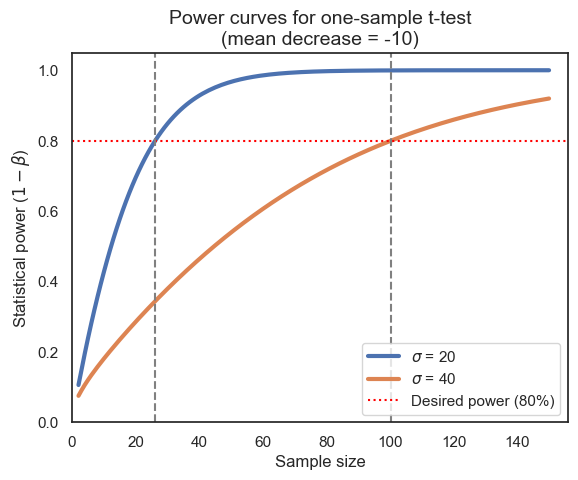

In [8]:
from statsmodels.stats.power import TTestPower

# Simulation parameters
diff = -10            # Mean level **decrease** compared to known population mean
std_devs = [20, 40]   # Different levels of standard deviation
power = 0.8           # Desired power (80%)
alpha = 0.05          # Significance level
max_sample_size = 151 # Sample sizes to consider

# Calculate power curves
power_analysis = TTestPower()

power_curves = {}
for sd in std_devs:
    power_curves[sd] = [
        power_analysis.power(
            effect_size=diff/sd,
            alpha=alpha,
            nobs=n,
            alternative='smaller',
        ) for n in range(2, max_sample_size)]  # Start from 2 observations
    
# Calculate required sample sizes for each SD
required_sample_sizes = {}
for sd in std_devs:
    required_sample_sizes[sd] = power_analysis.solve_power(
        effect_size=diff/sd,
        power=power,
        alpha=alpha,
        nobs=None, # this is the one we want to solve
        alternative='smaller',
    )

# Plotting
# plt.figure(figsize=(10, 6))
for sd, powers in power_curves.items():
    plt.plot(
        range(2, max_sample_size),
        powers,
        label=fr'$\sigma$ = {sd}',
        lw=3)

plt.axhline(
    y=power,
    ls=':', c='red',
    label=f'Desired power ({power*100:.0f}%)')

for sd, powers in required_sample_sizes.items():
    plt.axvline(
        required_sample_sizes[sd],
        linestyle='--',color='gray',
        # label=f'N for power=0.8, SD={sd}',
    )

plt.xlabel("Sample size", fontsize=12)
plt.ylabel(r"Statistical power ($1 - \beta$)", fontsize=12)
plt.title(
    f"Power curves for one-sample t-test\n(mean decrease = {diff})",
    fontsize=14)
plt.legend()
# plt.grid(axis='y', linestyle='--')
plt.xlim(0, max_sample_size+5)
plt.ylim(0, 1.05);

This plot illustrates how increasing standard deviation (greater variability in the data) lowers the statistical power for a given sample size and effect size. To maintain a desired level of power when dealing with higher variability, we need to increase the sample size.

The plot is also a valuable tool for planning studies. It helps us determine the appropriate sample size needed to detect a specific effect with a desired level of confidence, given the expected variability in the data. If our study didn't find a significant result, this plot can help us assess whether it was due to a lack of a true effect or simply a lack of power (insufficient sample size). Finally, by understanding the relationship between power, sample size, and variability, we can allocate the research resources more efficiently, avoiding underpowered studies that are unlikely to yield meaningful results.

#### Unpaired t-test

Effect size and variance are inversely related. As seen just above, Cohen's d is the standardized difference between two group means, divided by the pooled standard deviation (which is a measure of variability).

Power calculations for independent t-tests serve a crucial role in experimental design and interpretation of results. Their primary purpose is to determine the minimum sample size needed in each group to detect a statistically significant difference between the means of two independent groups, with a specified level of confidence. In the following example, we the [`TTestIndPower`](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestIndPower.html) function for analyzing statistical power in the context of _independent two-sample t-tests_. In particular, the `plot_power` function within provides a convenient way to visualize the relationship between power, the effect size and sample size in a _two-sample t-test_ scenario.

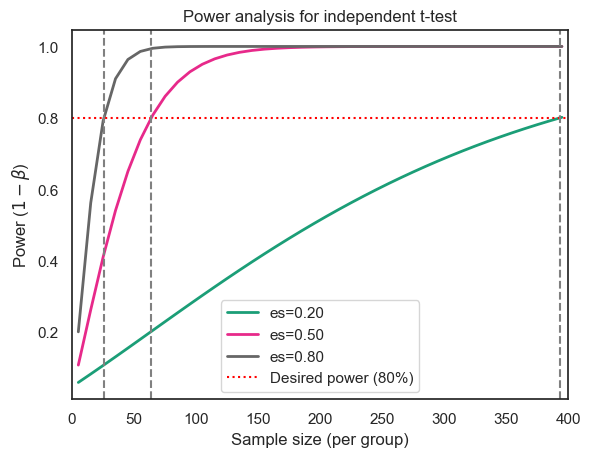

In [9]:
from statsmodels.stats.power import TTestIndPower

# Analysis setup
power_analysis = TTestIndPower()
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.arange(5, 401, 10)
alpha = 0.05
power = 0.8  # Desired power (80%)

# Calculate required sample sizes for each SD
required_sample_sizes = {}
for es in effect_sizes:
    required_sample_sizes[es] = power_analysis.solve_power(
        effect_size=es,
        power=power,
        alpha=alpha,
        # parameters are a little different than in TTestPower
        ratio=1, # ratio nobs2 over nobs1
        nobs1=None, # this is the one we want to solve
        alternative='two-sided',
    )

# Plotting with plot_power function
power_analysis.plot_power(
    dep_var='nobs',
    nobs=sample_sizes,
    effect_size=effect_sizes,
    alpha=alpha
)

plt.axhline(
    y=power,
    ls=':', c='red',
    label=f'Desired power ({power*100:.0f}%)')

for es, powers in required_sample_sizes.items():
    plt.axvline(
        required_sample_sizes[es],
        linestyle='--',color='gray',
        # label=f'N for power=0.8, SD={sd}',
    )

plt.xlabel('Sample size (per group)')
plt.ylabel(r'Power ($1 - \beta$)')
plt.xlim(0, max(sample_sizes)+5)
plt.title('Power analysis for independent t-test')
plt.legend();

Each curve corresponds to a different effect size, showing how power increases with sample size for that particular effect. The curves have a characteristic sigmoidal (S-shaped) pattern, reflecting how power initially increases rapidly with sample size and then levels off. Finally, larger effect sizes lead to steeper curves, meaning they require smaller sample sizes to achieve the same level of power.

In conclusion, as the sample size per group increases, so does the power to detect a statistically significant difference between the means. This means _larger samples are more likely to identify a true effect_, as demonstrated in the figure below.

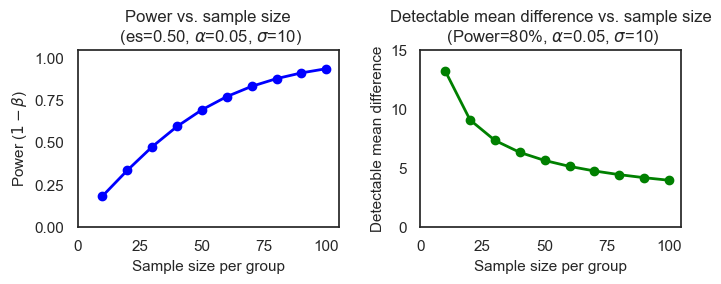

In [10]:
# Parameters
alpha = 0.05                          # Significance level
power = 0.8                           # Desired power
sd = 10                               # Standard deviation
mean_difference = 5                   # Mean difference tested
sample_sizes = np.arange(10, 101, 10) # Range of sample sizes per group

# Power analysis for subplot 1
power_analysis = TTestIndPower()
powers = [
    power_analysis.power(
        effect_size=mean_difference/sd,
        alpha=alpha,
        nobs1=n,
        ratio=1.0
    ) for n in sample_sizes]

# Calculate mean differences for subplot 2
mean_diffs = [
    power_analysis.solve_power(
        effect_size=None,
        power=power,
        alpha=alpha,
        nobs1=n,
        ratio=1.0,
    # multiply the solved effect size by SD to get the mean difference
    )*sd for n in sample_sizes]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(7, 3)) # 1 row, 2 columns
sns.set_theme(style="whitegrid")
# Subplot 1: Power vs. Sample Size
axes[0].plot(
    sample_sizes, powers,
    'o-', color='blue', linewidth=2)
axes[0].set_xlabel('Sample size per group', fontsize=11)
axes[0].set_ylabel(r'Power ($1 - \beta$)', fontsize=11)
axes[0].set_title(f'Power vs. sample size\n \
(es={mean_difference/sd:.2f}, $\\alpha$={alpha}, $\\sigma$={sd})', fontsize=12)
# axes[0].grid(axis='y', linestyle='--')
axes[0].set_xlim(0, max(sample_sizes)+5)
axes[0].set_ylim(0, 1.05)

# Subplot 2: Mean Difference vs. Sample Size
axes[1].plot(
    sample_sizes, mean_diffs,
    'o-', color='green', linewidth=2)
axes[1].set_xlabel('Sample size per group', fontsize=11)
axes[1].set_ylabel('Detectable mean difference', fontsize=11)
axes[1].set_title(
    f'Detectable mean difference vs. sample size\n \
(Power={power*100:.0f}%, $\\alpha$={alpha}, $\\sigma$={sd})', fontsize=12)
# axes[1].grid(axis='y', linestyle='--')
axes[1].set_xlim(0, max(sample_sizes)+5)
axes[1].set_ylim(0, 15)

plt.tight_layout();

#### The choice of 80% power

The horizontal dashed line at 0.8 represents the commonly desired power level of 80%. The vertical dashed lines intersect the power curves at the points where 80% power is achieved. These intersection points reveal the minimum sample size required per group for each standard deviation to reliably detect the specified effect size.

The 80% power standard emerged as a compromise between Type I and Type II errors. In the early days of statistical practice, limited resources and computational power made it difficult to achieve very high power. A power of 80% was seen as a reasonable balance, offering a good chance of detecting a real effect without requiring excessively large sample sizes.

Now, setting power too low (e.g., 60%) increases the risk of Type II errors (e.g., 40%), meaning we're more likely to miss a true effect. On the other hand, striving for very high power (e.g., 99%) often demands much larger sample sizes, which may not be feasible or ethical in many research settings. If the consequences of a Type II error (missing a real effect) are severe, we might opt for a higher power level, even if it means a larger sample size. For example, in a clinical trial for a life-saving drug, a higher power (e.g., 90%) might be preferred.

80% power strikes a middle ground, offering a reasonable probability of detecting an effect while keeping sample size requirements manageable. In early-stage research or pilot studies, a lower power level (e.g., 70%) might be acceptable, as the goal is often to gather preliminary evidence rather than draw definitive conclusions. Also, if we have strong _prior evidence suggesting the presence of an effect_, we might be comfortable with lower power. Don't to forget that if we expect a very large effect size, we might be able to achieve adequate power with a smaller sample size. However, it's still important to conduct a power analysis to confirm this.

#### Paired t-test

Let's dive into a concrete example of power calculation for a _paired t-test_ using the [`pingouin`](https://pingouin-stats.org/build/html/generated/pingouin.power_ttest.html) package in Python.

The `power_ttest` method provides a single function that can calculate power, sample size, effect size, or significance level, depending on which parameters are provided. It handles one-sample, paired-sample, and two-sample independent t-tests (with equal sample sizes; use [`power_ttest2n`](https://pingouin-stats.org/build/html/generated/pingouin.power_ttest2n.html) for unequal sample sizes). However, it doesn't directly create plots like `plot_power` does.

Imagine a biotech is studying the effectiveness of a new cognitive training program aimed at improving memory scores. It plans to administer a memory test to participants _before and after_ the training program. Researchers want to determine the sample size needed to have an 80% chance (power = 0.8) of detecting a statistically significant improvement in memory scores after the training.

Required sample sizes for 80% power in a paired t-test:
ES of paired differences = 0.2: 199 pairs
ES of paired differences = 0.5: 34 pairs
ES of paired differences = 0.8: 15 pairs


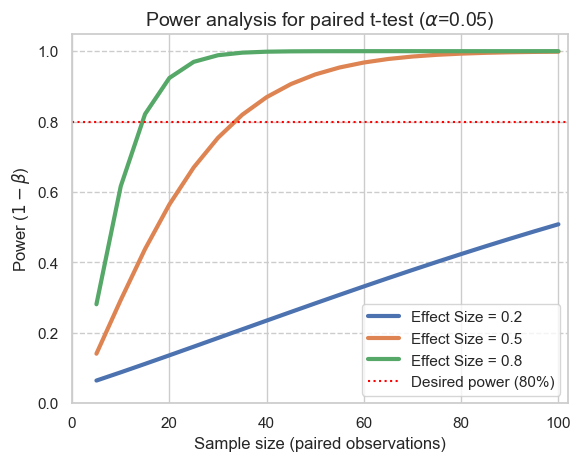

In [11]:
import pingouin as pg

# Parameters
effect_sizes = np.array([0.2, 0.5, 0.8]) # Different effect sizes (Cohen's d)
alpha = 0.05                             # Significance level
sample_sizes = np.arange(5, 101, 5)      # Sample sizes/number of pairs to consider
power = 0.8                              # Desired power (80%)

# Calculate and print required sample sizes
print("Required sample sizes for 80% power in a paired t-test:")
for es in effect_sizes:
    required_n = pg.power_ttest(
        d=es,
        n=None, # parameter to solve
        power=power,
        alpha=alpha,
        contrast='paired',
        alternative='two-sided',
    )
    print(f"ES of paired differences = {es}: {int(np.ceil(required_n))} pairs")

# Plotting
# plt.figure(figsize=(10, 6))
for es in effect_sizes:
    power_values = pg.power_ttest(
        d=es,
        n=sample_sizes,
        power=None, # parameter we want to solve
        alpha=alpha,
        contrast='paired',
        alternative='two-sided', # default
    )

    plt.plot(
        sample_sizes,
        power_values,
        # 'o-',
        label=f'Effect Size = {es:.1f}',
        lw=3)

plt.axhline(
    y=power,
    ls=':', c='red',
    label=f'Desired power ({power*100:.0f}%)')

plt.xlabel('Sample size (paired observations)', fontsize=12)
plt.ylabel(r'Power ($1 - \beta$)', fontsize=12)
plt.title(
    f"Power analysis for paired t-test ($\\alpha$={alpha})",
    fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.xlim(0, max(sample_sizes)+2)
plt.ylim(0, 1.05);

The curves clearly demonstrate that power increases as the sample size per group increases. This means that with larger samples, we have a higher probability of detecting a statistically significant difference between the groups, even if the true effect size is small.

Furthermore, each curve represents a different level of standard deviation (SD) within the groups. As the SD increases (i.e., the data becomes more spread out), the curves shift to the right. This means we need a larger sample size to achieve the same level of power when the data is more variable.

### Choosing a sample size

#### Tools for power calculations

As we've seen, sample size calculations for a desired level of statistical power require to specify the following:

- Significance level ($\alpha$): The acceptable risk of a false positive (Type I error).
- Desired power ($1 - \beta$): The desired probability of correctly detecting a true effect.
- Minimum effect size: The smallest effect size we consider meaningful and worth detecting.
- Standard deviation (SD): A measure of the variability or scatter in the data. Alternatively, for proportion-based tests, we would need the expected proportion.

The type of test (one-tailed or two-tailed) also affects sample size calculations. One-tailed tests generally require smaller sample sizes but are only appropriate when we have a strong directional hypothesis. Importantly, power analysis formulas often rely on _assumptions_ about the distribution of the data (e.g., normality). Violating these assumptions can affect the accuracy of the calculations.

Numerous online tools and software packages can assist with power analysis. Some popular options include:

- [G*Power](https://www.gpower.hhu.de) for comparing means
- [Power and Sample Size](https://www.powerandsamplesize.com), for comparing means, K means, proportions, time-to-event data, odds ratio, etc.
- R packages such as [`pwr`](https://github.com/heliosdrm/pwr) and [`simr`](https://github.com/pitakakariki/simr) that offer comprehensive power analysis functions within the R statistical environment
- the Python libraries `statsmodels`, with the `solve_power` method from the `TTestPower` and `TTestIndPower` classes, and `pingouin` with `power_ttest`, as we have seen in our previous examples. The first library offers another option with the direct function import of [`tt_ind_solve_power`](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html).

For example, the required sample size per group to achieve 80% power in detecting a 17 kg mean difference between men and women, given a standard deviation of 17 kg and an alpha level of 0.05 can be obtained as follows.

In [12]:
from statsmodels.stats.power import tt_ind_solve_power

# Parameters
effect_size = 17 / 17  # Cohen's d (mean_diff / sd_diff)
alpha = 0.05           # Significance level
desired_power = 0.8    # Target power

# Calculate sample size (directly)
n_per_group = tt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=desired_power,
    ratio=1.0,          # Equal sample sizes
    alternative='two-sided'
)

# Display result (clear and concise)
print(f"Required sample size per group: {int(np.ceil(n_per_group))}")

Required sample size per group: 17


If we collect weights from 17 men and 17 women in many experiments, assuming the standard deviation (SD) of 17 kg is close to the true population SD, we'd expect approximately 80% of those experiments to yield statistically significant results (P < 0.05). This is because our power analysis indicated that a sample size of 17 per group is sufficient to achieve 80% power to detect a mean difference of 17 kg with this SD.

Important Considerations:

- Assumption of Equal Variance (Homoscedasticity): This calculation assumes that the _variances_ in the men and women groups are _equal_. If we have reason to believe the variances might be different, we should use a different power analysis function or adjust the calculation accordingly.
- Assumption of Normality: The power analysis and the interpretation of the results rely on the assumption that the weight data are _normally distributed_ within each group. If this assumption is violated, the results might not be accurate.
- Standard Deviation: The _standard deviation_ of 17 kg is an estimate. It's crucial to have a _reliable estimate_ of this value, either from prior studies or pilot data.
- Effect Size: The chosen effect size of 1.0 (17 kg / 17 kg) is considered a _large effect_. If we expect a smaller effect, we will need a larger sample size to achieve the same power.

#### Sample sizes for comparing proportions (A/B test)

We can use a simplified formula derived from the principles of hypothesis testing for proportions, assuming the sample proportions follow a normal distribution, and incorporating the desired power and significance level:

$$n=(z_{\alpha/2}+z_\beta)^2 \times \frac{p_1(1-p_1)+p_2(1-p_2)}{(p_1-p_2)^2}$$

The term $(p_1 - p_2)$ represents the effect size, i.e., the difference in proportions we want to detect, $z_{\alpha/2}$ is the z-score corresponding to the significance level ($\alpha$) divided by 2 which defines the critical region in each tail of the distribution where we would reject the null hypothesis (here it's a two-sided test), and $z_\beta$ is the z-score corresponding to the desired power ($1-\beta$) which defines the distance between the alternative hypothesis distribution and the critical region.

Some methods calculate power and sample size based on exact statistical distributions (like the binomial distribution for proportions), while others use approximations (like the normal approximation to the binomial). These approximations might introduce _slight discrepancies_, especially with smaller sample sizes. Furthermore, the specific numerical algorithms used to solve for power and sample size can vary between functions, leading to slight differences in the results. There are more sophisticated methods available (e.g., using the binomial distribution directly) for complex scenarios or when precise calculations are required.

While the normal distribution is often used to approximate the binomial distribution in hypothesis tests for proportions (especially with larger sample sizes), there are also a few tools, such as [`samplesize_proportions_2indep_onetail`](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.samplesize_proportions_2indep_onetail.html), that allow us to calculate sample sizes for comparing proportions without relying on the normality assumption.

In [13]:
from scipy.stats import norm

# parameters
p2= 5/100   # baseline proportion, e.g., complication rate
p1 = 3/100  # 2% absolute change, i.e., from 5% to 3%
alpha = 0.05
power = .9

# Calculate sample size using manual calculations
za = norm.ppf(1-(alpha/2))
zb = np.abs(norm.ppf(1-power))

n_per_group_manual = (za+zb)**2 * (p1*(1-p1) + p2*(1-p2)) / (p1-p2)**2

# Calculate sample size using statsmodels
from statsmodels.stats.proportion import samplesize_proportions_2indep_onetail
n_per_group_statsmodels = samplesize_proportions_2indep_onetail(
    diff=-2/100,  # here p1 = prop2 + diff
    prop2=5/100,  # here prop2 is the proportion for the reference
    power=power,
    ratio=1,
    alpha=alpha,
)

# Display results
print(f"Required sample size per group (using manual calculations): \
{int(np.ceil(n_per_group_manual))}")
print(f"Required sample size per group (using statsmodels): \
{int(np.ceil(n_per_group_statsmodels))}")


Required sample size per group (using manual calculations): 2013
Required sample size per group (using statsmodels): 2016


#### Incorporating FPRP into sample size decisions

The False Positive Report Probability (FPRP) can be estimated before conducting an experiment based on the chosen significance level, desired power, and the prior probability of the null hypothesis (H0) being true.

As shown in the next table, the FPRP is dramatically affected by the prior probability:

- 1% Prior Probability: This represents a _highly speculative scenario_ with _little evidence_ to support the alternative hypothesis. In this case, a significant result has an 86.1% chance of being a _false positive_. Less than 1% of significant results would be true positives.
- 50% Prior Probability: When there's solid theoretical or empirical backing for the alternative hypothesis, the FPRP drops significantly to 5.9%. This suggests a _much higher likelihood_ of a significant result being a _true discovery_.

In [14]:
alphas = [.05, .01, .001]     # significance levels tested
powers = [.80, .90, .95, .99] # power levels tested
pprobas= [0.01, 0.1, .25, .5] # estimates of prior probability

print("How alpha, power, and prior probability affect FPRP\n")

print(f"alpha\tpower\t{100*pprobas[0]}%\t{100*pprobas[1]}%\t{100*pprobas[2]}%\t{100*pprobas[3]}%")
print("-"*45, end='')

for alpha in alphas:
    print(f"\n{alpha:4.3f}", end="")
    
    for power in powers:
        print(f"\n\t{100*power}%", end="")
        
        for proba in pprobas:
            print(f"\t{100*((1-proba)*alpha)/(((1-proba)*alpha)+(proba*power)):3.1f}%", end="")

How alpha, power, and prior probability affect FPRP

alpha	power	1.0%	10.0%	25.0%	50.0%
---------------------------------------------
0.050
	80.0%	86.1%	36.0%	15.8%	5.9%
	90.0%	84.6%	33.3%	14.3%	5.3%
	95.0%	83.9%	32.1%	13.6%	5.0%
	99.0%	83.3%	31.3%	13.2%	4.8%
0.010
	80.0%	55.3%	10.1%	3.6%	1.2%
	90.0%	52.4%	9.1%	3.2%	1.1%
	95.0%	51.0%	8.7%	3.1%	1.0%
	99.0%	50.0%	8.3%	2.9%	1.0%
0.001
	80.0%	11.0%	1.1%	0.4%	0.1%
	90.0%	9.9%	1.0%	0.3%	0.1%
	95.0%	9.4%	0.9%	0.3%	0.1%
	99.0%	9.1%	0.9%	0.3%	0.1%

In essence, a study's context is crucial. A well-designed experiment with a high prior probability of a true effect can yield reliable significant findings, while a speculative study with low prior probability is more likely to produce misleading results.

Therefore, it's imperative to consider the prior probability when designing and interpreting studies. When faced with a low prior probability, researchers should adjust their expectations and potentially employ stricter significance thresholds or gather additional evidence to strengthen the credibility of their findings.

#### Complexities when computing sample size

While power analysis provides a valuable framework for calculating sample size, the process is rarely straightforward. Several factors can influence the accuracy and applicability of our calculations. This section will address these complexities and offer practical guidance for making informed sample size decisions.

- Choosing the significance level $\alpha$
  - Think beyond tradition: don't blindly default to the conventional $\alpha = 0.05$.
  - Prior probability matters: consider the **prior probability** of a true effect (pre-study evidence).
  - FPRP as a guide: estimate the False Positive Report Probability (FPRP) to understand the **risk of false positives**.
  - One-tailed vs. two-tailed: choose the appropriate test directionality based on the research question.
- Choosing desired statistical power ($1 - \beta$)
  - Balance the FPRP: aim for a power level that, in combination with the chosen $\alpha$, results in a **reasonably low FPRP**.
  - Weigh the consequences: consider the relative costs of Type I and Type II errors. If **missing a true effect** is very costly, opt for higher power.
- Selecting the effect size
  - Scientific relevance: focus on the **smallest effect size** that would be **scientifically meaningful**, not just statistically significant.
  - Don't rely solely on published estimates: published effect sizes might be biased or not relevant to our specific context.
  - Consider standard effect sizes: use **Cohen's guidelines** (e.g., 1/5th the SD, or 0.2 → small, half the SD, or 0.5 → medium, 0.8 → large) as a starting point, but don't blindly adhere to them.
  - Don't anchor on the expectations: base the sample size on the effect size we want to detect, not necessarily what we expect to find.
  - Think in ratios: if estimating the exact effect size is difficult, consider framing it as a _ratio relative to the standard deviation_ (e.g., "we want to detect an effect size equal to half the SD").
- Estimating expected variability
  - Minimize variability: if possible, design the study to **reduce the variability** within groups (e.g., through stricter inclusion criteria, more controlled experimental conditions).
  - Pilot studies: conduct **pilot studies** to get a realistic estimate of variability. Small pilot studies often underestimate true variability (see the table below).
  - Published estimates with caution: be aware that published standard deviations might be biased downward due to selective reporting.
- Planning for unequal sample sizes
  - Trade-offs: if we need to reduce the sample size in one group, we should be prepared to increase the other group's size even more to maintain power.
  - Statistical guidance: consult a statistician for optimal strategies in dealing with unequal group sizes.
- Accounting for dropouts
  - Anticipate attrition: always overestimate the sample size to account for potential dropouts during the study.
  - Retention strategies: consider strategies to minimize dropout rates to preserve statistical power.
- Leveraging paired designs
  - Increased power: if the study design allows for pairing observations (e.g., pre- and post-test measures), take advantage of it! **Paired t-tests are more powerful** than independent t-tests for the same effect size.
  - Sample size adjustment: the required sample size for a paired t-test is typically smaller than that for an unpaired test, but keep in mind that we'll need twice the number of total observations (one for each member of the pair).

In [15]:
from scipy.stats import chi2

def W(n, alpha=1 - 0.95):
    t2=chi2(df=n-1).ppf(alpha/2) # based on the equation from Sheskin 2011
    t1=chi2(df=n-1).ppf(1-(alpha/2))
    return np.sqrt((n-1)/t1), np.sqrt((n-1)/t2)
    
sample_sizes = [2, 3, 5, 10, 25, 50, 100, 500, 1000]

print("95% CI of a SD\n")
print("n\t95% CI of SD")
print("--------------------------", end='')

for sample_size in sample_sizes:
    print(f"\n{sample_size}", end="")
    print(f"\t{W(sample_size)[0]:.2f}×SD - {W(sample_size)[1]:05.2f}×SD", end="")

95% CI of a SD

n	95% CI of SD
--------------------------
2	0.45×SD - 31.91×SD
3	0.52×SD - 06.28×SD
5	0.60×SD - 02.87×SD
10	0.69×SD - 01.83×SD
25	0.78×SD - 01.39×SD
50	0.84×SD - 01.25×SD
100	0.88×SD - 01.16×SD
500	0.94×SD - 01.07×SD
1000	0.96×SD - 01.05×SD

The discrepancy between a sample's standard deviation (SD) and the true population SD can be substantial, particularly when dealing with small sample sizes. For example, with a sample size of only 3, the population SD could be up to 6.28 times larger than the sample SD, as reflected in the confidence interval for the standard deviation. Since the required sample size for a t-test is proportional to the square of the SD, if the SD obtained in a pilot study is half the true population SD, the calculated sample size would be merely one-quarter of what it should be.

This highlights the importance of using caution when relying on pilot studies or _small samples_ to estimate variability for power analysis. It underscores the value of obtaining **reliable estimates of the population standard deviation**, either from larger pilot studies, previous research, or expert knowledge. When such information is unavailable, conservative estimates of variability or adjustments to sample size calculations should be considered to avoid underpowered studies.

### The simulation-based approach

While traditional power analysis methods (like those we've discussed) rely on theoretical formulas and assumptions, a simulation-based approach offers a more flexible and intuitive way to estimate sample size.

Here's how it works:

1. Define the study design: clearly articulate the research question, the type of study (e.g., randomized controlled trial, observational study), and the primary outcome measure.
2. Simulate data Under H0: generate multiple datasets under the assumption that the null hypothesis is true (no effect). We can use distributions (e.g., normal, binomial) that mimic the expected characteristics of the data.
3. Simulate data under Ha: generate multiple datasets under the assumption that the alternative hypothesis is true, using an effect size we consider clinically meaningful.
4. Analyze and compare: perform the planned statistical test (e.g., t-test, chi-square) on each simulated dataset. Compare the proportion of significant results under H0 (false positives) to the proportion under Ha (true positives) for various sample sizes.
5. Determine sample size: choose the smallest sample size where the proportion of true positives is acceptably high (e.g., 80% power) while keeping the proportion of false positives at or below the chosen significance level (e.g., 5%).

As a practical example, let's say we're designing a study to evaluate a new drug's effect on systolic blood pressure. We hypothesize that the drug will reduce systolic blood pressure by 10 mmHg compared to a placebo. We want to determine the sample size needed to have an 80% chance of detecting this effect.

In [16]:
# For reproducibility
np.random.seed(111)

def simulate_study(n, mean_difference=0):
    control_group = np.random.normal(130, 15, n)  # Mean = 130, SD = 15
    treatment_group = np.random.normal(130 - mean_difference, 15, n)
    _, p_value = ttest_ind(control_group, treatment_group)
    return p_value < 0.05  # True if significant, False otherwise

# Simulation parameters
mean_difference = 10
alpha = 0.05
power = 0.8
num_simulations = 1000 # Number of simulations
max_sample_size = 80   # Max number of samples per group

# Run simulations
results = []
# Iterate over sample sizes, starting from 10, up to the max_sample_size, in steps of 5
for n in range(10, max_sample_size, 5):
    # Simulate num_simulations (1000 in this case) studies for the current sample size (n)
    # The simulate_study function returns True for significant results (p < 0.05)
    signif_results = sum(simulate_study(n, mean_difference=mean_difference) for _ in range(num_simulations))

    # Calculate the power as the proportion of simulations that resulted in a significant finding
    power = signif_results / num_simulations

    # Store the current sample size and the calculated power for later
    results.append((n, power))

# Find the smallest sample size that achieves 80% power
for n, power in results:
    if power >= 0.8:
        print(f"Required sample size per group: {n}")
        break

Required sample size per group: 35


This simulation would run t-tests on randomly generated data and find the minimum sample size needed to detect the hypothesized effect with 80% power. While it can handle **complex study designs** and **various outcome distributions**, especially when normality assumptions don't hold, it can be **computationally intensive** for large simulations.

## Testing for equivalence or noninferiority

Traditional hypothesis testing focuses on demonstrating a significant difference between treatments. However, in certain contexts, like generic drug development, the goal shifts towards demonstrating equivalence or noninferiority compared to a standard drug.

### Bioequivalence

The U.S. Food and Drug Administration (FDA) defines two drug formulations as **bioequivalent** if the 90% confidence interval (CI) of the ratio of their peak concentrations in blood plasma falls entirely within the range of **0.80 to 1.25** (note that the reciprocal of 80% is $1/0.8=125%$). This means the generic drug's performance is expected to be within 20% of the reference drug's performance in most cases, a difference considered clinically insignificant.

Using a 90% confidence interval (CI) for each of the two one-sided tests results in an overall 95% confidence level for the equivalence conclusion. This might seem counterintuitive, but it's a result of how the two tests and their associated CIs combine.

### Interpreting equivalence and noninferiority tests

- **Equivalence**: when the entire 90% CI lies within the 0.80-1.25 equivalence zone, the generic drug is deemed equivalent to the standard drug.
- **Non-equivalence**: if the 90% CI falls completely outside the equivalence zone, the drugs are considered not equivalent.
- **Inconclusive results**: a 90% CI that straddles the equivalence zone (partially inside, partially outside) means the data are inconclusive regarding equivalence.
- **Noninferiority**: when the lower limit of the 90% CI exceeds 0.80, the new drug is considered noninferior. This indicates that the new drug is either superior to the standard drug or only slightly inferior, remaining within the zone of practical equivalence.

<img src="https://static.s4be.cochrane.org/app/uploads/2022/01/Figure-1-scaled.jpg" alt="Defining superiority, equivalence and non-inferiority in clinical trials" style="width: 800px;"/>

There is a nice interactive visualization of [equivalence, non-inferiority and superiority testing](https://rpsychologist.com/d3/equivalence/), where we can play with the effect size, the sample, size and the margin and see how these parameters affect the equivalence.

### Two One-Sided Tests (TOST)

Standard hypothesis testing (null hypothesis significance testing or NHST) is designed to detect differences between groups or treatments. However, in equivalence testing, our goal is to demonstrate that two treatments are not meaningfully different - that they fall within a pre-defined range of equivalence.

The problem with applying NHST directly to equivalence testing is that failing to reject the null hypothesis (H0: no difference) doesn't prove equivalence. It could simply mean our study lacked sufficient power to detect a small difference. The TOST procedure cleverly adapts NHST to the equivalence framework by posing **two separate null hypotheses**:

1. H01: the true mean ratio is less than or equal to the lower equivalence bound (0.80 in the FDA example).
2. H02: the true mean ratio is greater than or equal to the upper equivalence bound (1.25 in the FDA example).

By conducting two **one-sided tests**, each with a significance level of 0.05, we essentially create two "null hypotheses of non-equivalence."

Now, how do we interpret TOST results?

- Reject Both Null Hypotheses: if we reject both H01 and H02 (i.e., both one-sided p-values are less than 0.05), we conclude that the true mean ratio lies within the equivalence interval with 90% confidence. This is the desired outcome for demonstrating equivalence.
- Fail to Reject Either Null Hypothesis: if we fail to reject either H01 or H02 (p-value ≥ 0.05), we cannot conclude equivalence. This doesn't necessarily mean the treatments are not equivalent; it could be due to insufficient statistical power.

Equivalence and non-inferiority testing present unique challenges and require specialized methods beyond the scope of this jupyter-book, so that consulting with a statistician familiar with the relevant regulatory guidelines is strongly recommended.

## Assessing diagnostic accuracy

Statistical significance is crucial for determining if an effect exists, but it doesn't tell the whole story when evaluating the **performance** of diagnostic tests or classification models. In the realm of medical diagnosis, epidemiology, and machine learning, we need metrics that assess how well a test or model can distinguish between different conditions or classes.

Sensitivity, specificity, and Receiver Operating Characteristic (ROC) curves provide a powerful framework for quantifying and visualizing diagnostic **accuracy**. They offer insights into the trade-offs between true positive and false positive rates, allowing us to select optimal decision thresholds and compare the performance of different tests or models.

### Definitions

Deciding whether a clinical laboratory result is normal or abnormal involves a similar logic to statistical hypothesis testing, but with a focus on diagnostic accuracy:

- **False Negative (FN)**: a test result is classified as negative (normal) when the patient actually has the disease.
- **False Positive (FP)**: a test result is classified as positive (abnormal) when the patient actually does not have the disease.

The accuracy of a diagnostic test is assessed by two fundamental metrics:

- **Sensitivity**, also commonly referred to as **recall**, **hit rate** or **True Positive Rate (TPR)**, quantifies how well the test _identifies individuals with the disease_. It's the proportion of true positives (those who have the disease and test positive; TP) out of all individuals with the disease. Mathematically, it's represented as $\text{sensitivity}=\frac{\text{TP}}{\text{TP}+\text{FN}}$, where FN represents false negatives (those with the disease who test negative).
- **Specificity**, also commonly referred to as **selectivity** or **True Negative Rate (TNR)**, quantifies how well the test _identifies individuals without the disease_. It's the proportion of true negatives (those who don't have the disease and test negative; TN) out of all individuals without the disease. Mathematically, it's represented as: $\text{specificity}=\frac{\text{TN}}{\text{TN}+\text{FP}}$, where FP represents false positives (those without the disease who test positive).

|               | Disease present (true) | Disease absent (false) | 
| ------------- |:----------------------:|:----------------------:|
| Test positive |   True Positive (TP)   |  False Positive (FP)   |
| Test negative |  False Negative (FN)   |   True Negative (TN)   |

Test **accuracy**, sometimes abbreviated as **ACC**, is a measure of how often a diagnostic test correctly classifies individuals as having or not having a particular disease or condition. It's the proportion of true results (both true positives and true negatives) out of all test results: $\text{accuracy}=\frac{\text{TP}+\text{TN}}{\text{TP}+\text{FP}+\text{TN}+\text{FN}}$.

While accuracy is a useful overall metric, it can be misleading when dealing with _imbalanced datasets_, where the number of samples in one class is significantly higher than the other. In such cases, a classifier could achieve high accuracy by simply predicting the majority class most of the time, even if it performs poorly on the minority class. **Balanced accuracy (BA)** addresses this issue by taking the average of sensitivity (true positive rate) and specificity (true negative rate): $\text{BA}=\frac{\text{TPR}+\text{TNR}}{2}$.

While sensitivity and specificity are fundamental metrics, they don't directly answer the questions that matter most to patients and clinicians:

- If a test result is positive, what is the probability that the patient actually has the disease?
- If a test result is negative, what is the probability that the patient truly does not have the disease?

These questions are addressed by two crucial measures of diagnostic accuracy:

- **Positive Predictive Value (PPV)**, also commonly referred to as **precision**, is the probability that a positive test result correctly indicates the presence of the disease, i.e., $\text{PPV}=\frac{\text{TP}}{\text{TP}+\text{FP}}$.
- **Negative Predictive Value (NPV)**: the probability that a negative test result correctly indicates the absence of the disease., i.e., $\text{NPV}=\frac{\text{TN}}{\text{TN}+\text{FN}}$.

While the Benjamini-Hochberg procedure offers a valuable method for controlling the false discovery rate in multiple hypothesis testing, the general concept of FDR extends beyond this specific method. In the context of diagnostic accuracy, we can also define the FDR as the proportion of positive test results that are actually incorrect (false positives) Mathematically, the **False Discovery Rate (FDR)** in diagnostic testing can be expressed as $\text{FDR}=\frac{\text{FP}}{\text{FP}+\text{TP}}$. The FDR is the complement of precision: $\text{PPV} = 1 - \text{FDR}$.

Similarly, the **False Positive Rate (FPR)**, sometimes called the "fall-out" or "false alarm rate", is the probability of a positive test result (or a positive prediction by a model) when the condition or event being tested for is not actually present, i.e., $\text{FDR}=\frac{\text{FP}}{\text{FP}+\text{TN}}$. The FPR is the complement of specificity: $\text{TNR}=1-\text{FDR}$.

Finally, while sensitivity and specificity are crucial, they often paint an incomplete picture of a test's **overall performance**, especially in situations with imbalanced class distributions (e.g., when the disease is rare). The **F1-score** addresses this by _combining both precision (positive predictive value) and recall (sensitivity)_ into a single metric. The F1-score is the _harmonic mean of precision and recall_. It's a balanced measure that gives equal weight to both the ability to correctly identify positive cases (recall) and the ability to avoid false positives (precision), i.e., $\text{F1-score}=2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$.

### ROC curves

#### Decision thresholds

Sensitivity and specificity provide valuable insights into a test's performance at a fixed threshold. However, in practice, the optimal **threshold** for a diagnostic test can vary depending on the clinical setting and the consequences of different types of errors (false positives and false negatives).

Receiver Operating Characteristic (ROC) curves offer a solution by visualizing the trade-offs between sensitivity and specificity across a range of possible thresholds. An ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

<img src="https://docs.eyesopen.com/toolkits/cookbook/python/_images/roc2img.svg" alt="Example of a simple ROC curve" style="width: 400px;"/>

An ROC curve is created by plotting the true positive rate (sensitivity) on the y-axis against the false positive rate (1-specificity) on the x-axis for _various decision thresholds_ of a test. The resulting curve illustrates the relationship between _sensitivity and specificity_ as the threshold changes. A perfect test would have a curve that hugs the top-left corner of the plot (high sensitivity and high specificity at all thresholds). A random guess would result in a diagonal line (no better than chance). At one extreme (bottom-left), the test is overly _conservative_, never producing a positive result, even for true cases. This translates to zero sensitivity but perfect specificity. At the other extreme (upper-right), the test is overly _liberal_, always yielding a positive result, regardless of the true condition. This results in 100% sensitivity but zero specificity.

The choice of threshold for a diagnostic test significantly affects its sensitivity and specificity, creating an inherent trade-off:

- High threshold: setting a high threshold (requiring stronger evidence for a positive result) leads to:
  - Low sensitivity: the test is less likely to detect true cases of the disease, resulting in more false negatives.
  - High specificity: the test is more likely to correctly identify those without the disease, resulting in fewer false positives.
-Low threshold: setting a low threshold (requiring less evidence for a positive result) leads to:
  - High sensitivity: the test is more likely to detect true cases of the disease, minimizing false negatives.
  - Low specificity: the test is less likely to correctly identify those without the disease, leading to more false positives.

The optimal threshold depends on the specific clinical context and the relative consequences of false negatives and false positives. For example, screening tests for serious diseases often use a lower threshold to maximize sensitivity (catching as many cases as possible), even if it leads to more false positives that require further testing.

#### Area Under the Curve (AUC)

The **Area Under the ROC Curve (AUC)** is a single metric summarizing a diagnostic/classifier's overall ability to discriminate between positive and negative classes across all possible thresholds.:

- $\text{AUC} = 1.0$: this represents a **perfect** classifier, one that can flawlessly distinguish between positive and negative cases across all thresholds.
- $0.5 < \text{AUC} < 1.0$: a classifier with an AUC greater than 0.5 is considered a **good** classifier, as it performs better than random chance. The closer the AUC is to 1.0, the better the classifier's ability to discriminate between classes.
- $\text{AUC} = 0.5$: an AUC of 0.5 indicates that the classifier is no better than **random** guessing. It's essentially a coin flip whether the classifier will make a correct prediction.
- $0.0 < \text{AUC} < 0.5$: a classifier with an AUC less than 0.5 is performing worse than random chance. It's making **systematic errors** and could potentially be improved by simply inverting its predictions.
- $\text{AUC} = 0.0$: this represents a completely **incorrect** classifier. It consistently makes the wrong prediction for every instance.

#### ROC and Python

In practice, these values (true positives, false positives, etc.) are derived from the results of a diagnostic test or a **machine learning** model applied to a dataset where the true labels are known. For instance, using Python's [`scikit-learn` library](https://scikit-learn.org/stable/index.html), we can train and evaluate various machine learning classifiers on labeled data, obtaining the confusion matrix that allows us to compute metrics like the F1-score and [draw the ROC curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py).

While a thorough exploration of machine learning is beyond the scope of this book, it's important to recognize that these tools offer powerful ways to assess and optimize the performance of diagnostic tests and classification models.

### Case studies

#### Porphyria test in 0.01% prevalence

Porphyria is a rare group of disorders that affect the body's ability to produce heme, a component of hemoglobin. The prevalence is estimated to be 1 in 10,000 individuals. We have a diagnostic test for porphyria with the following characteristics:

- Sensitivity: 82% (82 out of 100 patients with porphyria will test positive).
- Specificity: 96.3% (963 out of 1000 individuals _without_ porphyria will test negative, 3.7% of individuals _without_ porphyria will test positive).

|               | Has Porphyria | Does not have Porphyria |     Total |
|:------------- |:-------------:|:-----------------------:| ---------:|
| Positive test |       82      |          36,996         |    37,078 |
| Negative test |       18      |         962,904         |   962,922 |
| Total         |      100      |         999,900         | 1,000,000 |

Despite the test's high sensitivity (82%) and specificity (96.3%), the probability that a patient with a positive (abnormal) test result actually has porphyria is surprisingly low: only 82 out of 37078 individuals, i.e., 0.22%, or approximately 1 in 500. This means that the vast majority (99.8%) of positive results are false positives.

On the other hand, the test is highly reliable for ruling out porphyria. Of those who test negative, a staggering 99.998% truly do not have the disease. This high negative predictive value offers strong reassurance to individuals who receive a negative test result. A negative result on this test provides strong evidence that an individual does not have porphyria.

#### Porphyria test in 50% prevalence

The low prevalence of porphyria (1 in 10,000) significantly impacts the test's predictive value, even with high sensitivity and specificity.

Let's analyze a scenario where we're testing whether individuals have siblings, with a prevalence of 50% (meaning half the population has siblings). We'll consider a sample of 1000 individuals and the same test characteristics (sensitivity = 82%, specificity = 96.3%) to see how the predictive values change compared to the rare disease example.

|               | Has Porphyria | Does not have Porphyria | Total |
|:------------- |:-------------:|:-----------------------:| -----:|
| Positive test |      410      |              19         |   429 |
| Negative test |       90      |             481         |   571 |
| Total         |      500      |             500         |  1000 |

In this scenario, approximately only 4.4% of positive tests are false positives (19 out of 429).

#### HIV test

This case study examines the performance of an HIV test with a sensitivity of 99.9% and a specificity of 99.6%. We will simulate screening a population of 1 million individuals where the prevalence of HIV is 10%.

|               | Has HIV  | Does not have HIV  | Total     |
|:------------- |:--------:|:------------------:| ---------:|
| Positive test |  99,900  |         3,600      |   103,500 |
| Negative test |     100  |       896,400      |   896,500 |
| Total         | 100,000  |       900,000      | 1,000,000 |

Of the approximately 103,500 positive tests, we estimate that 3.6% will be false positives due to the inherent limitations of the test.

Let's now simulate the screening of 1 million individuals where the prevalence of HIV is 0.1%.

|               | Has HIV  | Does not have HIV  | Total     |
|:------------- |:--------:|:------------------:| ---------:|
| Positive test |    999   |         3,996      |     4,995 |
| Negative test |      1   |       995,004      |   995,005 |
| Total         |   1000   |       999,000      | 1,000,000 |

In a scenario with a low disease prevalence of 0.1%, a significant proportion of positive test results, i.e., 80%, are likely to be false positives. Even with a highly specific test, the low prevalence means that the number of false positives can far outweigh the number of true positives. This leads to a higher chance of healthy individuals being incorrectly identified as positive.

The false positive rate isn't solely determined by the test's specificity. The prevalence of the disease within the tested population significantly influences the proportion of positive tests that are false positives.

### Analogy with statistical hypothesis testing

Interpreting the results of a diagnostic test, much like interpreting statistical significance, requires a nuanced understanding of the context. Just as the prevalence of a disease influences the meaning of a positive test, the prior probability of a true effect shapes our interpretation of statistical significance. Here's a closer look at the parallels between the two frameworks:

- _False negatives_ in diagnostic tests are akin to _Type II errors_ in hypothesis testing. Both represent missed opportunities to detect a true condition or effect.
- _False positives_ in diagnostic tests are akin to _Type I errors_ in hypothesis testing. Both represent erroneous claims of a condition or effect when none truly exists.
- _Sensitivity_ in diagnostic tests mirrors _power_ ($1 - \beta$) in hypothesis testing. Both quantify the ability to correctly identify a true positive.
- _Specificity_ in diagnostic tests mirrors _one minus the significance level_ ($1 - \alpha$) in hypothesis testing. Both measure the ability to correctly identify a true negative.

### Bayes revisited

In the realm of diagnostic testing, Bayes' Theorem provides a powerful framework for _updating_ our beliefs about a patient's disease status based on the results of a test. By incorporating **prior knowledge** (prevalence) with the test's characteristics (sensitivity and specificity), we can calculate the probability of the patient _actually_ having the disease given a positive test result (positive predictive value, PPV) or the probability of not having the disease given a negative result (negative predictive value, NPV).

A key component of Bayes' Theorem is the **likelihood ratio (LR)**, which quantifies how much a test result should change our belief in the presence of the disease. The **positive likelihood ratio (LR+)** is the probability of a positive test result in a patient with the disease divided by the probability of a positive test result in a patient without the disease:

$$\text{LR+} = \frac{\text{sensitivity}}{1 - \text{specificity}}$$

For example, if we take the previous case studies:

- Porphyria: $\text{LR+} = 0.82 / (1 - 0.963) = 22.2$
- HIV: $\text{LR+} = 0.999 / (1 - 0.996) = 249.75$

This means that a positive result is 22.2 times _more likely_ in someone with porphyria than someone without it, and 249.75 times more likely in someone with HIV.

Now, Bayes' theorem allows us to **update** the **pretest odds** (odds of disease before the test) to the **posttest odds** (odds of disease after the test) using the likelihood ratio as $\text{posttest odds} = \text{pretest odds} \times \frac{\text{sensitivity}}{1 - \text{specificity}} = \text{pretest odds} \times \text{likelihood ratio}$.

The following table illustrates this process for the porphyria and HIV examples:

| Who was tested?           | Pretest probability | Pretest odds | LR+    | Posttest probability | Posttest odds |
|:------------------------- |:-------------------:|:------------:|:------:|:--------------------:|:-------------:|
| Porphyria (random screen) |        0.0001       |    0.0001    |  22.2  |         0.0022       |      0.22%    |
| Porphyria (sibling)       |        0.50         |    1.0       |  22.2  |        22.2          |     95.7%     |
| HIV (high prevalence)     |        0.1          |    0.111     | 249.75 |        27.5          |     96.5%     |
| HIV (low prevalence)      |        0.001        |    0.001     | 249.75 |         0.25         |     20.0%     |

with $\text{odds} = \frac{\text{probability}}{1-\text{probability}}$ and $\text{probability} = \frac{\text{odds}}{1 + \text{odds}}$.

Even with a high LR+, a positive result in a random screen only slightly increases the probability of having porphyria (0.22%). This is because the disease is very rare. A positive result with a high LR+ is much more informative when the pretest probability is high, as in the case of a sibling test (95.7%). Finally, for the same test (HIV), the posttest probability varies dramatically depending on the pretest probability. A positive result in a high-prevalence population is much more likely to be a true positive than in a low-prevalence population.

## Conclusion

Throughout this chapter, we've explored the multifaceted concept of statistical significance, delving into its strengths, limitations, and potential pitfalls. We've seen that p-values, while valuable, can be misleading if interpreted in isolation or without considering factors like sample size, effect size, power, and prior probability.

We've also highlighted the importance of alternative approaches like confidence intervals, effect size estimation, and Bayesian methods, which offer a more comprehensive understanding of statistical inference. These tools can help us move beyond simple "significant" or "non-significant" dichotomies and towards a more nuanced interpretation of research findings.

By integrating these additional layers of evidence, we can arrive at more robust and informed conclusions. We can avoid the pitfalls of p-value hacking and publication bias, and we can focus on research that truly advances our understanding of the biological world.

## Session Information

The output below details all packages and version necessary to reproduce the results in this report.

In [17]:
!python --version
print("-------------")
# List of packages we want to check the version
packages = ['numpy', 'scipy', 'statsmodels', 'pingouin', 'matplotlib', 'seaborn']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    # Get the version of the package
    output = !pip show {package} | findstr "Version"
    # If the output is not empty, get the version
    if output:
        version = output[0].split()[-1]
    else:
        version = 'Not installed'
    # Append the version to the list
    versions.append(version)

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.3
-------------
numpy: 1.26.4
scipy: 1.13.1
statsmodels: 0.14.2
pingouin: 0.5.4
matplotlib: 3.9.0
seaborn: 0.13.2
